In [2]:
from __future__ import print_function
import pandas as pd

import numpy as np
import pretty_midi
from music21 import *
from midi2audio import FluidSynth
from IPython.display import display, Image, Audio
# For plotting
import mir_eval.display
import librosa.display

# For putting audio in the notebook
import IPython.display


import future        # pip install future
import builtins      # pip install future
import past          # pip install future
import six           # pip install six

import os
import glob

from pypianoroll import *
import pypianoroll as pr
from pypianoroll import Multitrack, Track
import copy

from madmom.audio.chroma import DeepChromaProcessor
from madmom.features.chords import DeepChromaChordRecognitionProcessor
import matplotlib.pyplot as plt

# .mid to .npy

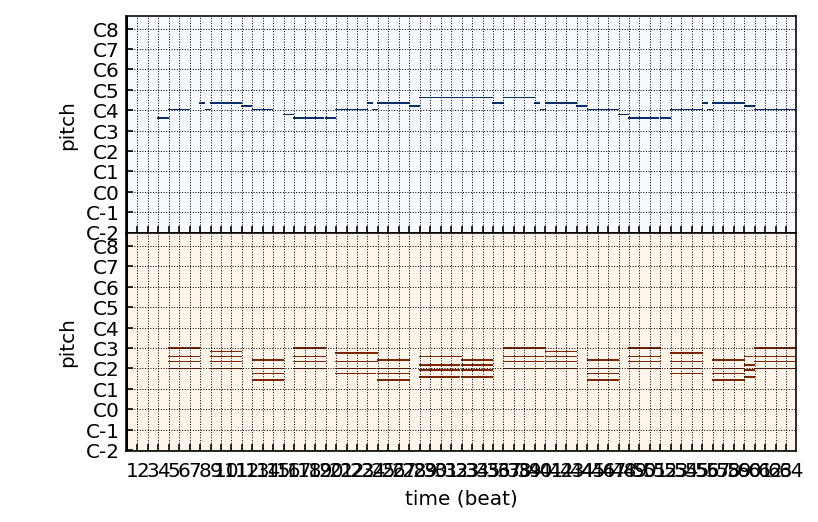

(768, 128, 2)


In [3]:
# Create a `pypianoroll.Multitrack` instance
multitrack = Multitrack(filepath='../data/preprocessing/mysong_mid_C/Amazing_Grace.mid', tempo=120.0, beat_resolution=12)


# Plot the multi-track piano-roll
fig, axs = multitrack.plot()
plt.show()

# save pypianoroll
pr.save('../data/preprocessing/mysong_npy_C/Amazing_Grace.npz', multitrack, compressed=True)
#pr.save('./mysong_npy_C/Amazing_Grace.npy', multitrack, compressed=False)

data = pr.load('../data/preprocessing/mysong_npy_C/Amazing_Grace.npz')
data_tracks = data.get_stacked_pianorolls()
data_bool = data_tracks.astype(bool)

np.save('../data/preprocessing/mysong_npy_C/Amazing_Grace.npy',data_bool)
data_npy_C = np.load('../data/preprocessing/mysong_npy_C/Amazing_Grace.npy')

# make length to be 64 bar long: 48* 64 = 3072

print(np.shape(data_npy_C)) #(3072, 128, 2)

# .mid to .wav

In [19]:
fs = FluidSynth('/usr/share/sounds/sf2/FluidR3_GM.sf2') # arch
fs.midi_to_audio('../data/preprocessing/mysong_mid_C/'+'Amazing_Grace.mid', '../data/preprocessing/mysong_wav_C/Amazing_Grace'+'.wav')

# chord extraction by Madmom

0
(1, 768, 84, 3)
data_save
768
data_new (64, 48, 84, 3)


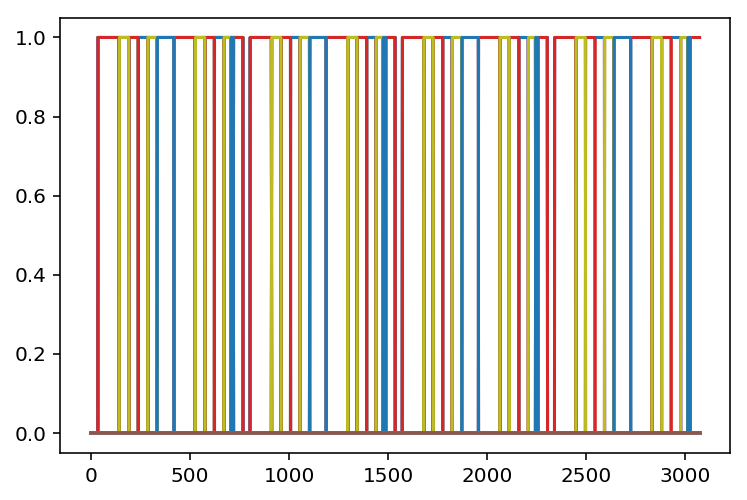

In [15]:
#length = 3072 # this is for 8bar_vae 
length = 768 # this is for Amazing_Grace

N_bar = length/48.0
N_beat = N_bar *4.0

names = ["C:min",
         "D:min",
         "E:min",
         "F:min",
         "G:min",
         "A:min",
         "B:min",
         "C:maj",
         "D:maj",
         "E:maj",
         "F:maj",
         "G:maj",
         "A:maj",
         "B:maj",
         "N",
         "C#:min",
         "D#:min",
         "E#:min",
         "F#:min",
         "G#:min",
         "A#:min",
         "B#:min",
         "C#:maj",
         "D#:maj",
         "E#:maj",
         "F#:maj",
         "G#:maj",
         "A#:maj",
         "B#:maj"]
         
notes = [[24,27,31], #Cmin
         [26,29,33], #Dmin
         [28,31,35], #Emin
         [29,32,36], #Fmin
         [31,34,38], #Gmin
         [21,24,28], #Amin
         [23,26,30], #Bmin
         [24,28,31], #Cmaj
         [26,30,33], #Dmaj
         [28,32,35], #Emaj
         [29,33,36], #Fmaj
         [31,35,38], #Gmaj
         [21,25,28], #Amaj
         [23,27,30], #Bmaj
         [], #N
         [25,28,32], #C#min
         [27,30,34], #D#min
         [29,32,36], #E#min
         [30,33,37], #F#min
         [32,35,39], #G#min
         [22,25,29], #A#min
         [24,27,31], #B#min
         [25,29,32], #C#maj
         [27,31,34], #D#maj
         [29,33,36], #E#maj
         [30,34,37], #F#maj
         [32,36,39], #G#maj
         [22,26,29], #A#maj
         [24,28,31]] #B#maj
         
notes_dict = {}
for i in range(len(names)):
    notes_dict[names[i]] = notes[i]

dcp = DeepChromaProcessor()
decode = DeepChromaChordRecognitionProcessor()
data_npy_C = np.load('../data/preprocessing/mysong_npy_C/Amazing_Grace.npy')
data_npy_C = np.reshape(data_npy_C,(1,length,128,2))
gen = np.zeros((1, length, 84, 3), dtype=bool)
gen[:,:,:,0:2] = data_npy_C[:,:,24:108,:]

gen_list = []
num = 0 # valid num
for i in range(0,1):
    print(i)
    try:    
        chroma = dcp('../data/preprocessing/mysong_wav_C/Amazing_Grace.wav')
        cho = decode(chroma)
    except Exception as e:
        print(e)
        continue
    
    cho_list = []
    c = 0
    duration = cho[-1][1] - cho[0][0]
    duration_beat = duration/(N_beat)
    last_center = cho[-1][1] - duration_beat/2.0
    first_center = cho[0][0] + duration_beat/2.0
    beat_list = np.linspace(first_center, last_center, num=int(N_beat))
    ##print(a)
    
    for beat in beat_list:
        if (cho[c][0]<= beat) & (beat <= cho[c][1]):
            cho_list.append(cho[c][2])
        else:
            cho_list.append(cho[c+1][2])
            c += 1
    n = 0
    ####### "N" chord cal #######
    for t in range(int(N_beat)):
        if cho_list[t] == 'N':
            n += 1
        else:
            pass
        
    if n >= 5:
        print('n:%s'%n)
        continue
    else:
        pass
    ###############################
    for t in range((int(N_beat))):
        if cho_list[t] == 'N':
            ##print('N')
            continue
        else:
            ##print(cho_list[t])
            for chord in notes_dict[cho_list[t]]:
                gen[i,12*t:12*(t+1),chord,2] = [True]*12
    
    gen_list.append(gen[i])
    print(np.shape(gen_list))
    num += 1
    
np.save('../data/preprocessing/mysong_npy_C/Amazing_Grace_madmom.npy',gen_list)
print('data_save')

# for 8bar_vae
data = np.load('../data/preprocessing/mysong_npy_C/Amazing_Grace_madmom.npy')
l = np.shape(data)[1]
print(l)
data_new = np.zeros((3072,84,3),dtype=bool)
i = 0
while i < len(data_new):
    data_new[i:i+l] = data
    i = i + l
    plt.plot(data_new[:,:,2])

data_new = np.reshape(data_new,(-1,48,84,3)) # 2 tracks + madmom chord track
print('data_new',np.shape(data_new))
np.save('../data/chord_roll/val/x_bar_chroma_Amazing_Grace.npy',data_new[:,:,:,0:2])
np.save('../data/chord_roll/val/y_bar_chroma_Amazing_Grace.npy',data_new[:,:,:,2:])
